# Import Packages and must load functions




This is an old script


In [2]:
import os
import ismrmrd
import ismrmrd.xsd
import glob
import numpy as np
import SimpleITK as sitk
from ismrmrdtools import show, transform
import matplotlib.pyplot as plt
import h5py

# based on https://github.com/ismrmrd/ismrmrd-python-tools/blob/master/recon_ismrmrd_dataset.py

def load_mrd_file_get_enc(filename):
    # Load file and return the encoding space of the first encoding space in the file (assuming only one)
    if not os.path.isfile(filename):
        print("%s is not a valid file" % filename)
        raise SystemExit
    dset = ismrmrd.Dataset(filename, create_if_needed=False)
    header = ismrmrd.xsd.CreateFromDocument(dset.read_xml_header())
    return header.encoding[0]


def print_stats_dset(dset) -> None:
    '''Print stats of the dataset dset'''
    header = ismrmrd.xsd.CreateFromDocument(dset.read_xml_header())
    enc = header.encoding[0]
    
    ncoils = header.acquisitionSystemInformation.receiverChannels
    nslices = enc.encodingLimits.slice.maximum + 1 if enc.encodingLimits.slice else 1
    nreps = enc.encodingLimits.repetition.maximum + 1 if enc.encodingLimits.repetition else 1
    ncontrasts = enc.encodingLimits.contrast.maximum + 1 if enc.encodingLimits.contrast else 1
    print(f"number of coils: {ncoils}, number of slices: {nslices}, number of repetitions: {nreps}, number of contrasts: {ncontrasts}")


def load_mrd_file_get_dset(filename):
    if not os.path.isfile(filename):
        print("%s is not a valid file" % filename)
        raise SystemExit
    return ismrmrd.Dataset(filename, create_if_needed=False)
    

def find_noise_scan(dset) -> None:
    # Find the noise scan in the dataset and return the acquisition number of the first imaging scan
    firstacq=0
    print("Number of acquisitions: ", dset.number_of_acquisitions())
    for acqnum in range(dset.number_of_acquisitions()):
        acq = dset.read_acquisition(acqnum)
        # TODO: Currently ignoring noise scans
        if acq.isFlagSet(ismrmrd.ACQ_IS_NOISE_MEASUREMENT):
            print("Found noise scan at acq ", acqnum)
            continue
        else:
            firstacq = acqnum
            print("Imaging acquisition starts acq ", acqnum)
            break
    print("First acquisition: ", firstacq)


def print_stats_of_enc(enc):
    # print stats of encoding space
    print("\n\tMatrix size: ")
    print('\t', enc.encodedSpace.matrixSize.x, enc.encodedSpace.matrixSize.y, enc.encodedSpace.matrixSize.z)
    print('\t', "Field of View encoded space: ")
    print('\t', enc.encodedSpace.fieldOfView_mm.x, enc.encodedSpace.fieldOfView_mm.y, enc.encodedSpace.fieldOfView_mm.z)
    print('\t', "Field of View recon space: ")
    print('\t', enc.reconSpace.fieldOfView_mm.x, enc.reconSpace.fieldOfView_mm.y, enc.reconSpace.fieldOfView_mm.z)
    print('\t', "Number of Slices: ")
    print('\t', enc.encodingLimits.slice.maximum)
    print('\t', "Number of Repetitions: ")
    print('\t', enc.encodingLimits.repetition.maximum)
    print('\t', "Number of Contrasts: ")
    print('\t', enc.encodingLimits.contrast.maximum)
    print('\t', "Number of Averages: ")
    print('\t', enc.encodingLimits.average.maximum)
    print('\t', "Number of Phases: ")
    print('\t', enc.encodingLimits.phase.maximum)
    print('\t', "Number of Sets: ")
    print('\t', enc.encodingLimits.set.maximum, '\n')


# Get all the T2W scans paths
def get_all_t2w_paths(verbatim=False):
    # Get all T2 TSE tra scans with glob pattern that satisfies the condition k_space_data_anon_output/*_patient_umcg_done/kspaces/meas_*_T2_TSE_tra_*.mrd'
    all_paths = glob.glob('k_space_data_anon_output/*_patient_umcg_done/kspaces/meas_*_T2_TSE_tra_*.mrd')
    # now also glob the pattern  k_space_data_anon_output/*_patient_umcg_done/kspaces/meas_*_t2_tse_tra_*.mrd'
    all_paths += glob.glob('k_space_data_anon_output/*_patient_umcg_done/kspaces/meas_*_t2_tse_tra_*.mrd')
    if verbatim:
        _ = [print(p) for p in all_paths]
        print('Number of scans: ', len(all_paths), '\n')
    return all_paths

print(os.getcwd())

c:\Users\qvloh\Documents\phd_lok\repos\umcglib\src\umcglib\kspace


# Some path data of the .mrd files


In [2]:
# filename = 'k_space_data_anon_output/0001_patient_umcg_done/kspaces/meas_MID00202_FID688156_T2_TSE_tra_obl-out_2.mrd'
# filename = 'k_space_data_anon_output/0002_patient_umcg_done/kspaces/meas_MID00039_FID701346_T2_TSE_tra_obl-out_2.mrd'
# filename = 'k_space_data_anon_output/0003_patient_umcg_done/kspaces/meas_MID00401_FID373323_t2_tse_traobl_p2_384-out_2.mrd'
# filename = 'k_space_data_anon_output/0004_patient_umcg_done/kspaces/meas_MID00460_FID707792_T2_TSE_tra_obl-out_2.mrd'
# filename = 'k_space_data_anon_output/0005_patient_umcg_done/kspaces/meas_MID00427_FID709025_T2_TSE_tra_obl-out_2.mrd'
# filename = 'k_space_data_anon_output/0006_patient_umcg_done/kspaces/meas_MID00392_FID708990_T2_TSE_tra_obl-out_2.mrd'
# filename = 'k_space_data_anon_output/0007_patient_umcg_done/kspaces/meas_MID00670_FID710360_T2_TSE_tra_obl-out_2.mrd'
# filename = 'k_space_data_anon_output/0008_patient_umcg_done/kspaces/meas_MID00220_FID710578_T2_TSE_tra_obl-out_2.mrd'
# filename = 'k_space_data_anon_output/0008_patient_umcg_done/kspaces/meas_MID00224_FID710582_T2_TSE_tra_obl-out_2.mrd'
# filename = 'k_space_data_anon_output/0009_patient_umcg_done/kspaces/meas_MID00693_FID711732_T2_TSE_tra_obl-out_2.mrd'
# filename = 'k_space_data_anon_output/0009_patient_umcg_done/kspaces/meas_MID00701_FID711740_T2_TSE_tra_obl-out_2.mrd'
# filename = 'k_space_data_anon_output/0010_patient_umcg_done/kspaces/meas_MID00060_FID711794_T2_TSE_tra_obl-out_2.mrd'

# Finding Noise scans - Sandbox


In [5]:
workdir = os.path.join("c:\\", "Users", "qvloh", "Documents", "phd_lok", "datasets", "umcg_prostate_kspace", "workspace", "output", "anon_kspaces")

# patient kspace file:
fname = os.path.join("0001_patient_umcg_done", 'meas_MID00202_FID688156_T2_TSE_tra_obl-out_2.mrd')
fpath_t2tra = os.path.join(workdir, fname)

# load the dataset
dset = load_mrd_file_get_dset(fpath_t2tra)

# Finding noise scans
find_noise_scan(dset)

Number of acquisitions:  26351
Found noise scan at acq  0
Imaging acquisition starts acq  1
First acquisition:  1


# All Header Information


In [10]:
dset = ismrmrd.Dataset(fpath_t2tra, create_if_needed=False)
header = ismrmrd.xsd.CreateFromDocument(dset.read_xml_header())

def print_headers(header):
    header_dict = vars(header)
    for key, value in header_dict.items():
        print(f"{key}:")
        if isinstance(value, type):
            for attr_name, attr_value in vars(value).items():
                print(f"\t{attr_name}: {attr_value}")
        else:
            print(f"\t{value}")

## Subject Information (Header info)


In [11]:
print_headers(header.subjectInformation)

patientName:
	None
patientWeight_kg:
	85.0
patientHeight_m:
	None
patientID:
	None
patientBirthdate:
	None
patientGender:
	M


## Measurement Information (Header info)


In [12]:
print_headers(header.measurementInformation)

measurementID:
	46133_14111923_14111931_202
seriesDate:
	None
seriesTime:
	None
patientPosition:
	patientPositionType.HFS
relativeTablePosition:
	None
initialSeriesNumber:
	None
protocolName:
	T2_TSE_tra obl
sequenceName:
	None
seriesDescription:
	None
measurementDependency:
	[measurementDependencyType(dependencyType='SenMap', measurementID='46133_14111923_14111931_198'), measurementDependencyType(dependencyType='Noise', measurementID='46133_14111923_14111931_198')]
seriesInstanceUIDRoot:
	None
frameOfReferenceUID:
	None
referencedImageSequence:
	None


## Acquisition Information (Header info)


In [130]:
print_headers(header.acquisitionSystemInformation)

systemVendor:
	SIEMENS
systemModel:
	Skyra
systemFieldStrength_T:
	2.89362
relativeReceiverNoiseBandwidth:
	0.793
receiverChannels:
	20
coilLabel:
	[coilLabelType(coilNumber=49, coilName='Body_18:1:B22'), coilLabelType(coilNumber=50, coilName='Body_18:1:B21'), coilLabelType(coilNumber=37, coilName='Spine_32:1:S52'), coilLabelType(coilNumber=38, coilName='Spine_32:1:S51'), coilLabelType(coilNumber=18, coilName='Body_18:1:B35'), coilLabelType(coilNumber=17, coilName='Body_18:1:B36'), coilLabelType(coilNumber=30, coilName='Body_18:1:B24'), coilLabelType(coilNumber=29, coilName='Body_18:1:B23'), coilLabelType(coilNumber=54, coilName='Body_18:1:B33'), coilLabelType(coilNumber=53, coilName='Body_18:1:B34'), coilLabelType(coilNumber=45, coilName='Spine_32:1:S63'), coilLabelType(coilNumber=46, coilName='Spine_32:1:S64'), coilLabelType(coilNumber=33, coilName='Spine_32:1:S54'), coilLabelType(coilNumber=34, coilName='Spine_32:1:S53'), coilLabelType(coilNumber=25, coilName='Body_18:1:B31'), coilL

## Encoding Information Encoded Space and Reconspace (Header info)

In [131]:
print('ENCODED SPACE')
print_headers(header.encoding[0].encodedSpace)

print('\nRECON SPACE')
print_headers(header.encoding[0].reconSpace)


ENCODED SPACE
matrixSize:
	matrixSizeType(x=640, y=688, z=1)
fieldOfView_mm:
	fieldOfViewMm(x=360.0, y=386.640015, z=4.5)

RECON SPACE
matrixSize:
	matrixSizeType(x=640, y=640, z=1)
fieldOfView_mm:
	fieldOfViewMm(x=180.0, y=180.0, z=3.0)


## Encoding Limits (header info)

In [132]:
print_headers(header.encoding[0].encodingLimits)

kspace_encoding_step_0:
	None
kspace_encoding_step_1:
	limitType(minimum=0, maximum=550, center=275)
kspace_encoding_step_2:
	limitType(minimum=0, maximum=0, center=0)
average:
	limitType(minimum=0, maximum=2, center=0)
slice:
	limitType(minimum=0, maximum=30, center=0)
contrast:
	limitType(minimum=0, maximum=0, center=0)
phase:
	limitType(minimum=0, maximum=0, center=0)
repetition:
	limitType(minimum=0, maximum=0, center=0)
set:
	limitType(minimum=0, maximum=0, center=0)
segment:
	limitType(minimum=0, maximum=0, center=0)
user_0:
	None
user_1:
	None
user_2:
	None
user_3:
	None
user_4:
	None
user_5:
	None
user_6:
	None
user_7:
	None


## Parallel Imaging (Header Info)

In [133]:
print_headers(header.encoding[0].parallelImaging)

accelerationFactor:
	accelerationFactorType(kspace_encoding_step_1=2, kspace_encoding_step_2=1)
calibrationMode:
	calibrationModeType.INTERLEAVED
interleavingDimension:
	interleavingDimensionType.AVERAGE


## Sequence Parameters (Header info)

In [134]:
print_headers(header.sequenceParameters)

TR:
	[8990.0]
TE:
	[112.0]
TI:
	[100.0]
flipAngle_deg:
	[150.0]
sequence_type:
	TurboSpinEcho
echo_spacing:
	[11.18]
diffusion:
	[]


# Convert to fastMRI data numpy format

### Helper Functions

In [11]:
def get_first_acquisition(dset):
    firstacq = 0
    for acqnum in range(dset.number_of_acquisitions()):
        acq = dset.read_acquisition(acqnum)
        if acq.isFlagSet(ismrmrd.ACQ_IS_NOISE_MEASUREMENT):
            continue
        else:
            firstacq = acqnum
            print("Imaging acquisition starts acq ", acqnum)
            break
    return firstacq


def zero_padding(data):
    sh_x, sh_y = [len(data[0,0,0,0,0]), len(data[0,0,0,0,0,0])]
    im_x, im_y = 2 * np.array([sh_x, sh_y])
    x_0 = im_x // 2 - (sh_x // 2)
    y_0 = im_y // 2 - (sh_y // 2)

    y3_shape = list(data.shape)
    y3_shape[5] *= 2
    y3_shape[6] *= 2
    y3 = np.zeros(y3_shape, dtype=np.complex64)

    y3[:, :, :, :, :, x_0:x_0 + sh_x, y_0:y_0 + sh_y] = data[:, :, :, :, :, :, :]

    return y3


def image_order(npdata):
    '''
    The main changes are:

    We calculate the half value using integer division (//) and add 1 to it. This is equivalent to rounding up.
    We create the y3 output array using np.zeros_like to avoid having to specify the shape and data type explicitly.
    Use advanced indexing to assign the even and odd slices directly from data to y3 in two vectorized operations. This should be significantly faster than using a loop.
    '''

    # Get the number of slices and calculate the half value (rounded up)
    slices = npdata.shape[0]
    half = (slices // 2)+1

    # Create output array of the same shape and data type as the input array 
    y3 = np.zeros_like(npdata, dtype=np.complex64)

    # Even slices first (0, 2, 4, ...) then odd slices (1, 3, 5, ...)
    y3[::2] = npdata[:half]
    y3[1::2] = npdata[half:]

    return y3

### Functions to reorder the data into numpy arrays

In [16]:
def get_first_acquisition(dset):
    firstacq = 0
    for acqnum in range(dset.number_of_acquisitions()):
        acq = dset.read_acquisition(acqnum)
        if acq.isFlagSet(ismrmrd.ACQ_IS_NOISE_MEASUREMENT):
            continue
        else:
            firstacq = acqnum
            print("Imaging acquisition starts acq ", acqnum)
            break
    return firstacq


def echo_train_length(dset):
    # This assumes:   (ET = echo train)
    # The noise acquisitions are made in the beginning.
    # The noise acquisition is made in the same slice as the first ET.
    # There are multiple slices.
    # After the first ET, it moves to the first ET of a different slice.
    # The first ET has the same length as the other ones.

    for n in range(dset.number_of_acquisitions()):
        if dset.read_acquisition(n).isFlagSet(ismrmrd.ACQ_IS_NOISE_MEASUREMENT):
            continue
        else:
            firstacq = n
            break
    for n in range(dset.number_of_acquisitions()):
        if dset.read_acquisition(n)._head.idx.slice != dset.read_acquisition(0)._head.idx.slice:
            return n - firstacq
    raise Exception("Couldn't find different slices in the dataset")


def echo_train_count(dset):
    # This assumes:
    # All the assumptions of echo_train_length
    # There are at least 2 averages (idx 0 and 1) avg0 and avg1
    # Higher index averages are acquired later

    enc = ismrmrd.xsd.CreateFromDocument(dset.read_xml_header()).encoding[0]

    if enc.encodingLimits.slice != None:
        nslices = enc.encodingLimits.slice.maximum + 1
    else:
        raise Exception("Couldn't find different slices in the dataset")
    
    count = 0
    for n in range(dset.number_of_acquisitions()):
        if dset.read_acquisition(n)._head.idx.average == 2:
            break
        if dset.read_acquisition(n)._head.idx.average == 1:
            count += 1

    return int(count/(nslices * echo_train_length(dset)))


def sample_data_ET_mask(dset, n_leave_ET=0):

    '''
    Arguments:
        - dset: data set in ismrmrd format
        - n_leave_ET: number of echo trains to remove from the end of the sampled data
    
    Returns:
        - If "n_leave_ET" stays 0, only all_data is returned. 
        - If not, the function returns all_data, subsampled_data.
    '''

    # Read the header and get encoding information
    header = ismrmrd.xsd.CreateFromDocument(dset.read_xml_header())
    enc = header.encoding[0]

    # Determine some parameters of the acquisition
    ncoils     = header.acquisitionSystemInformation.receiverChannels
    nslices    = enc.encodingLimits.slice.maximum + 1 if enc.encodingLimits.slice is not None else 1
    eNy        = enc.encodedSpace.matrixSize.y
    rNx        = enc.reconSpace.matrixSize.x
    eTL        = echo_train_length(dset)
    eTC        = echo_train_count(dset)
    firstacq   = get_first_acquisition(dset)

    print(f"ncoils: {ncoils}, nslices: {nslices}, eNy: {eNy}, rNx: {rNx}, eTL: {eTL}, eTC: {eTC}, firstacq: {firstacq}")

    # Initialize the data arrays
    fmri_ksp_format = np.zeros((nslices, ncoils, eNy + 1, rNx), dtype=np.complex64)
    if n_leave_ET != 0:
        fmri_ksp_format_sub = np.zeros((nslices, ncoils, eNy + 1, rNx), dtype=np.complex64)

    # Loop through the rest of the acquisitions and fill the data array with the kspace data 
    for acqnum in range(firstacq, dset.number_of_acquisitions()):
        acq    = dset.read_acquisition(acqnum)
        slice1 = acq.idx.slice
        y      = acq.idx.kspace_encode_step_1
        av     = acq._head.idx.average + 1

        print(f"acqnum: {acqnum}, slice: {slice1}, y: {y}, av: {av} out of {dset.number_of_acquisitions()} acquistions")
        print()

        if av == 1 or av == 2: #only getting the first two averages
            fmri_ksp_format[slice1, :, y, :] = acq.data

        if n_leave_ET != 0:
            if (acqnum <= eTL * nslices * (1 + eTC * 2 - n_leave_ET)):
                # Assumption: each of the 3 averages has 11 echo trains of 25 samples each.
                # and there is another echo train in the beginning (1 + 11 * 3) * 25 * 31 slices.
                # It also assumes the specific order of acquisitions: 1st ET for each slice, then 2nd ET for each slice...
                #
                # The last "n_leave_ET" ETs are removed by inversed order of aquisition from the end of the second average since it was considered as fully sampled, the k-space with the first two averages. 
                # If is wanted to remove from the end of the third change the if condition to: (acqnum <= eTL * nslices * (1 + eTC * 3 - n_leave_ET))
                fmri_ksp_format_sub[slice1, :, y, :] = acq.data

    # reorder the data from
    fmri_ksp_format = image_order(fmri_ksp_format)
    
    if n_leave_ET == 0:
        return fmri_ksp_format
    else:
        return fmri_ksp_format, fmri_ksp_format_sub


def sample_data_ET_mask_qvl(dset, n_leave_ET=0):

    '''
    Arguments:
        - dset: data set in ismrmrd format
        - n_leave_ET: number of echo trains to remove from the end of the sampled data
    
    Returns:
        - If "n_leave_ET" stays 0, only all_data is returned. 
        - If not, the function returns all_data, subsampled_data.
    '''

    # Read the header and get encoding information
    header = ismrmrd.xsd.CreateFromDocument(dset.read_xml_header())
    enc = header.encoding[0]

    # Determine some parameters of the acquisition
    ncoils     = header.acquisitionSystemInformation.receiverChannels
    nslices    = enc.encodingLimits.slice.maximum + 1 if enc.encodingLimits.slice is not None else 1
    eNy        = enc.encodedSpace.matrixSize.y
    rNx        = enc.reconSpace.matrixSize.x
    eTL        = echo_train_length(dset)
    eTC        = echo_train_count(dset)
    firstacq   = get_first_acquisition(dset)

    # Initialize the data arrays
    fmri_ksp_format = np.zeros((nslices, ncoils, eNy + 1, rNx), dtype=np.complex64)
    if n_leave_ET != 0:
        fmri_ksp_format_sub = np.zeros((nslices, ncoils, eNy + 1, rNx), dtype=np.complex64)

    # Loop through the rest of the acquisitions and fill the data array with the kspace data 
    for acqnum in range(firstacq, dset.number_of_acquisitions()):
        acq    = dset.read_acquisition(acqnum)
        slice1 = acq.idx.slice
        y      = acq.idx.kspace_encode_step_1
        av     = acq._head.idx.average + 1

        # print all vars nicely
        print(f"acqnum: {acqnum}, slice: {slice1}, y: {y}, av: {av} out of {dset.number_of_acquisitions()} acquistions")
        print()

        if av == 1 or av == 2: #only getting the first two averages
            fmri_ksp_format[slice1, :, y, :] = acq.data

        if n_leave_ET != 0:
            if (acqnum <= eTL * nslices * (1 + eTC * 2 - n_leave_ET)):
                # Assumption: each of the 3 averages has 11 echo trains of 25 samples each.
                # and there is another echo train in the beginning (1 + 11 * 3) * 25 * 31 slices.
                # It also assumes the specific order of acquisitions: 1st ET for each slice, then 2nd ET for each slice...
                #
                # The last "n_leave_ET" ETs are removed by inversed order of aquisition from the end of the second average since it was considered as fully sampled, the k-space with the first two averages. 
                # If is wanted to remove from the end of the third change the if condition to: (acqnum <= eTL * nslices * (1 + eTC * 3 - n_leave_ET))
                fmri_ksp_format_sub[slice1, :, y, :] = acq.data

    # reorder the data from
    fmri_ksp_format = image_order(fmri_ksp_format)
    
    if n_leave_ET == 0:
        return fmri_ksp_format
    else:
        return fmri_ksp_format, fmri_ksp_format_sub

#### Loading the file


In [14]:
workdir = os.path.join("c:\\", "Users", "qvloh", "Documents", "phd_lok", "datasets", "umcg_prostate_kspace", "workspace", "output", "anon_kspaces")

# patient kspace file:
fpath_t2tra = os.path.join(workdir, "0001_patient_umcg_done", 'meas_MID00202_FID688156_T2_TSE_tra_obl-out_2.mrd')
print(fpath_t2tra)

# Loading the data
dset = ismrmrd.Dataset(fpath_t2tra, create_if_needed=False)



c:\Users\qvloh\Documents\phd_lok\datasets\umcg_prostate_kspace\workspace\output\anon_kspaces\0001_patient_umcg_done\meas_MID00202_FID688156_T2_TSE_tra_obl-out_2.mrd
0001


#### re-ordering kspace data into numpy data

In [18]:
pat_dir_num = 10
pat_num = fpath_t2tra.split('\\')[pat_dir_num].split('_')[0]
print(pat_num)

# save the fully sampled kspace to temp directory so that we can load it later and not constantly have to rebuild it.
tmp_dir = os.path.join("c:\\", "Users", "qvloh", "Documents", "phd_lok", "datasets", "umcg_prostate_kspace", "workspace", "tmp")

# Reordering the kspace into a numpy array and saving it as a .npy file
fs_ksp = sample_data_ET_mask_qvl(dset, n_leave_ET=0)
np.save(os.path.join(tmp_dir, f'{pat_num}_fully_sampled.npy'), fs_ksp)
print(f"save to {os.path.join(tmp_dir, f'{pat_num}_fully_sampled.npy')}")

## The Root sum of Squares to validate the data


In [63]:
# load the fully sampled kspace if not already loaded into RAM.
# set to true if not loaded.

if False:
    fs_ksp = np.load(f'fully_sampled_kspaces_npy/pat{pat_num}_fully_sampled.npy')
    print(fs_ksp.shape)
    print(fs_ksp.dtype)

(31, 20, 689, 640)
complex64


In [23]:
# Print the fully sampled kspace shape
print(f'Fully sampled k-space shape: {fs_ksp.shape}')
print(fs_ksp[0, 0, :, :])
print(np.sum(fs_ksp[0, 0, :, :]))
print(np.sum(fs_ksp))

Fully sampled k-space shape: (31, 20, 689, 640)
[[ 0.0000000e+00+0.0000000e+00j  0.0000000e+00+0.0000000e+00j
   0.0000000e+00+0.0000000e+00j ...  0.0000000e+00+0.0000000e+00j
   0.0000000e+00+0.0000000e+00j  0.0000000e+00+0.0000000e+00j]
 [ 9.4808638e-07-2.3117755e-06j  3.9634760e-06-8.1304461e-07j
   1.5166588e-06+8.3656050e-06j ... -7.0617534e-07-2.4891924e-06j
   2.9271469e-06-2.8405339e-06j -6.5169297e-07+1.3243407e-06j]
 [-4.4419430e-06+3.2605603e-06j  1.4733523e-06-4.0759332e-06j
  -4.2151660e-06-5.5017881e-06j ... -1.7695129e-08+1.8223654e-06j
   1.8554274e-06+9.4226561e-07j  2.4251640e-06-4.4028275e-06j]
 ...
 [ 0.0000000e+00+0.0000000e+00j  0.0000000e+00+0.0000000e+00j
   0.0000000e+00+0.0000000e+00j ...  0.0000000e+00+0.0000000e+00j
   0.0000000e+00+0.0000000e+00j  0.0000000e+00+0.0000000e+00j]
 [ 0.0000000e+00+0.0000000e+00j  0.0000000e+00+0.0000000e+00j
   0.0000000e+00+0.0000000e+00j ...  0.0000000e+00+0.0000000e+00j
   0.0000000e+00+0.0000000e+00j  0.0000000e+00+0.000000

Fully sampled k-space shape: (31, 20, 689, 640)
Image array shape: (31, 689, 640)


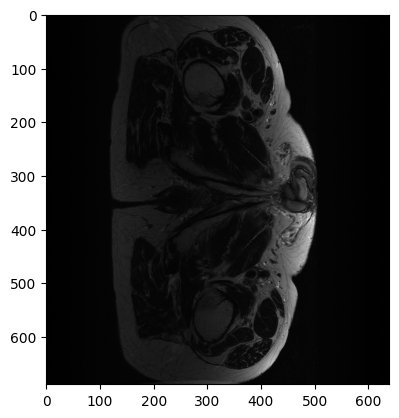

In [24]:
# Print the fully sampled kspace shape
print(f'Fully sampled k-space shape: {fs_ksp.shape}')

# Read the header and get encoding information
header = ismrmrd.xsd.CreateFromDocument(dset.read_xml_header())
enc = header.encoding[0]

# Determine some parameters of the acquisition
rNx = enc.reconSpace.matrixSize.x
eNy = enc.encodedSpace.matrixSize.y
eNz = enc.encodedSpace.matrixSize.z
ncoils = header.acquisitionSystemInformation.receiverChannels

# Perform image reconstruction for each slice
nslices = fs_ksp.shape[0]
images = np.zeros((nslices, fs_ksp.shape[2], fs_ksp.shape[3]), dtype=np.float32)
print(f'Image array shape: {images.shape}')

for slice_ in range(nslices):
    # Extract a single slice along the z direction
    if fs_ksp.shape[1] > 1:
        kspace_slice = fs_ksp[slice_, :, :, :]
    else:
        kspace_slice = fs_ksp[slice_, 0, :, :, :]

    # Perform inverse Fourier transform to obtain image
    im = transform.transform_kspace_to_image(kspace_slice, [1, 2])

    # Root sum of squares
    im = np.sqrt(np.sum(np.abs(im) ** 2, 0))

    # Store the resulting image
    images[slice_, :, :] = im

# show an image with matplotlib
plt.imshow((images[0,:,:]), cmap='gray')
plt.show()

In [25]:
print(eNz)
img = sitk.GetImageFromArray(images[:,:,:])
sitk.WriteImage(img, os.path.join(tmp_dir, f'pat{pat_num}_rss_recon.nii.gz'))

1
